In [1]:
import pandas as pd; import numpy as np; import matplotlib as mtpl; import matplotlib.pyplot as plt;import time;import timeit
import random;from scipy import stats

font = {'family' : 'serif','weight' : 'ultralight','size'   : 14};mtpl.rc('font', **font)

In [37]:
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

def Smooth121(x):
    signal = x
    length = len(signal)
    output = np.zeros(length-2)
    coef= np.array([1,2,1])
    for i in range(length - 2):
        output[i]= np.sum(signal[i:i+3] * coef / 4)
    return output

def Haar(t,x,plot=False,smooth=False):
    x=np.array(x);t=np.array(t)    
    #Cálculo deltas
    deltas_t=[];epsilons=[]
    for i in range(1,int(len(t)/2)+1):  #steps: i from 1 to n/2 
        deltas_t.append(t[i:]-t[:-i]) #0= Delta_t1, 1= Delta_t2, ..., [n/2]-1 = Delta_tn/2
    for i in range(1,len(deltas_t)+1): #for all my deltas_t (all steps-differences, de 1 en 1, de 2 en 2, etc)
        epsilons.append(deltas_t[i-1][:-i]/(deltas_t[i-1][:-i]+deltas_t[i-1][i:]))
    x=x[:-1];t=t[:-1]
    print('t samples:',len(t))
    print('deltas_t steps: from 1 to',len(deltas_t))
    print('epsilons steps:',len(epsilons))

    #Cálculo fluctuaciones
    Hs=[]; delta_t=[]; ep_min=0.25; ep_max=1-ep_min; calib=2; counter=0
    for H in range(2,len(x)-1,2):
        for start in range(len(x)-H-1):
            int1=np.sum(x[start:start+int(H/2)]*deltas_t[0][start:start+int(H/2)]/deltas_t[int(H/2)-1][start])
            int2=np.sum(x[start+int(H/2):start+H]*deltas_t[0][start+int(H/2):start+H]/deltas_t[int(H/2)-1][start+int(H/2)])
            counter+=1
            if ep_min<epsilons[int(H/2)-1][start] and epsilons[int(H/2)-1][start]<ep_max:
                #Hs.append(calib*abs(int2-int1)) #S_1
                Hs.append((calib*(int2-int1))**2) #S_2 (falta despues sacar raíz)
                delta_t.append(deltas_t[int(H/2)-1][start]+deltas_t[int(H/2)-1][start+int(H/2)]) #No logaritmicos           

    print(counter-len(Hs),' fluctuaciones eliminadas (',(counter-len(Hs))/counter*100,'%)')
    
    #Paso a dataframes
    data_df=pd.DataFrame(data={'delta t':delta_t , 'Hs': Hs}); data_sorted=data_df.sort_values('delta t',axis=0).reset_index(drop=True)

    #plt.subplots(figsize=(15, 7))
    #plt.title(' Scatter Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
    #plt.plot(data_df['delta t'],np.sqrt(data_df['Hs']),'.');plt.show()

    max_t=max(np.log10(data_sorted['delta t'])); min_t=min(np.log10(data_sorted['delta t']))
    n_bins=int(((max_t)-(min_t))*20); rango_int=(max_t-min_t)/n_bins; time=np.array([]); ave_values=np.array([]); upper=np.array([]); lower=np.array([]);
    for i in range(n_bins):
        interval=data_sorted[(i*rango_int+min_t<=np.log10(data_sorted['delta t']))&(np.log10(data_sorted['delta t'])<min_t+(i+1)*rango_int)]
        time=np.append(time,((i*rango_int+min_t)+((i+1)*rango_int+min_t))/2)
        ave_values=np.append(ave_values,np.sqrt(interval.mean()[1]))        ## Tomo el sqrt del <[2*(x1-x2)]^2> ...
        upper=np.append(upper,np.sqrt(interval.mean()[1]+interval.std()[1]/np.sqrt(len(interval))))
        lower=np.append(lower,np.sqrt(interval.mean()[1]-interval.std()[1]/np.sqrt(len(interval))))
        
    if smooth==False:
        smooth_val=ave_values
    if smooth==True:
        smooth_val=Smooth121(ave_values)
        upper=Smooth121(upper)
        lower=Smooth121(lower)
        time=time[1:-1]
    val_mask = np.isfinite(smooth_val)
    
    time=time[val_mask] #??
    smooth_val=smooth_val[val_mask] #??
    
    if plot=='plot':
        plt.subplots(figsize=(15, 7))
        plt.title(' Sin test Haar fluctuation',fontsize=20);plt.xlabel('Log\u2081\u2080\u0394 t (Ky)',fontsize=18);plt.ylabel('Log\u2081\u2080 S\u2082(\u0394 t)^1/2',fontsize=18)
        for i in range(n_bins):
            plt.axvline(x = i*rango_int+min_t,linestyle='-.',linewidth=0.5)
        plt.plot(time,np.log10(smooth_val),'.-',color='black',linewidth=2,label='Log binning')
        plt.legend()
        plt.show()

    return data_sorted['delta t'],data_sorted['Hs'],time,smooth_val,upper,lower

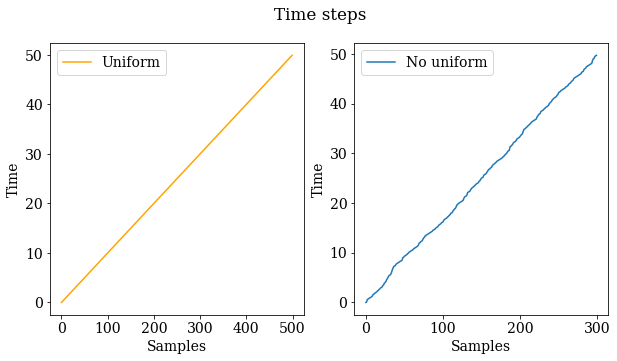

In [2]:
#points=50; 
#t = np.arange(0, points, 0.1); #500 points
#n=300; t2 = np.sort(random.sample(range(len(t)),n))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
fig.suptitle('Time steps')
ax1.plot(t, '-',label='Uniform',color='orange');ax1.set(xlabel='Samples', ylabel='Time')
ax2.plot(t[t2], '-',label='No uniform');ax2.set(xlabel='Samples', ylabel='Time')
ax1.legend();ax2.legend()

#plt.savefig('12-SinteticA1-0-time steps.pdf',bbox_inches='tight')

plt.show()

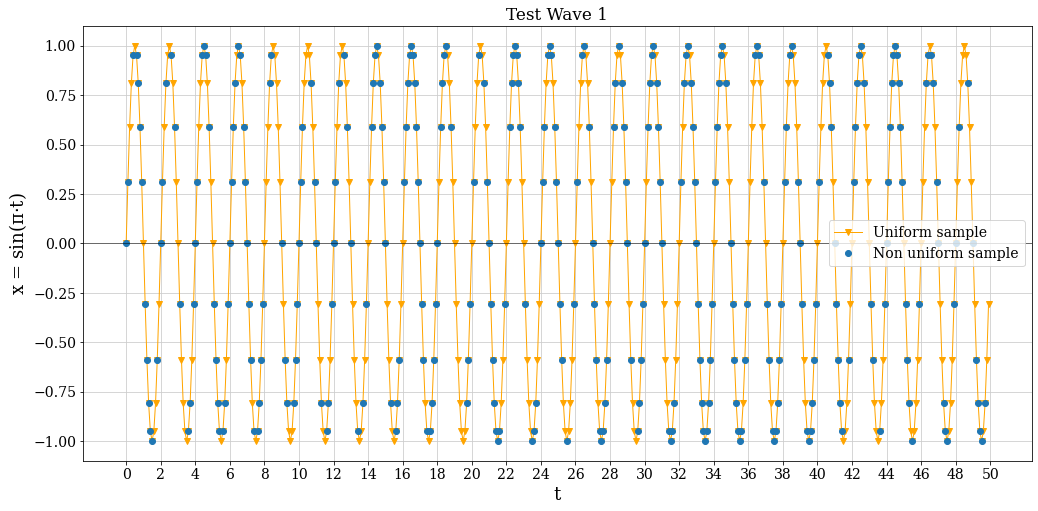

In [4]:
x = np.sin(np.pi*t); x2 = x[t2]# Periodos: 2t

plt.subplots(figsize=(17, 8))
plt.plot(t, x,'v-',linewidth=1,markersize=6,label='Uniform sample',color='orange')
plt.plot(t[t2],x2,'o',markersize=6,label='Non uniform sample')
plt.title('Test Wave 1');plt.xlabel('t',fontsize=18);plt.ylabel('x = sin(\u03C0'+r'$\cdot$'+'t)',fontsize=18)
plt.grid(True, which='both',color='0.8');
plt.axhline(y=0, color='k',linewidth=0.5)
plt.legend()
x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)


#plt.savefig('12-SinteticA1-1-test wave1.pdf',bbox_inches='tight')
plt.show()

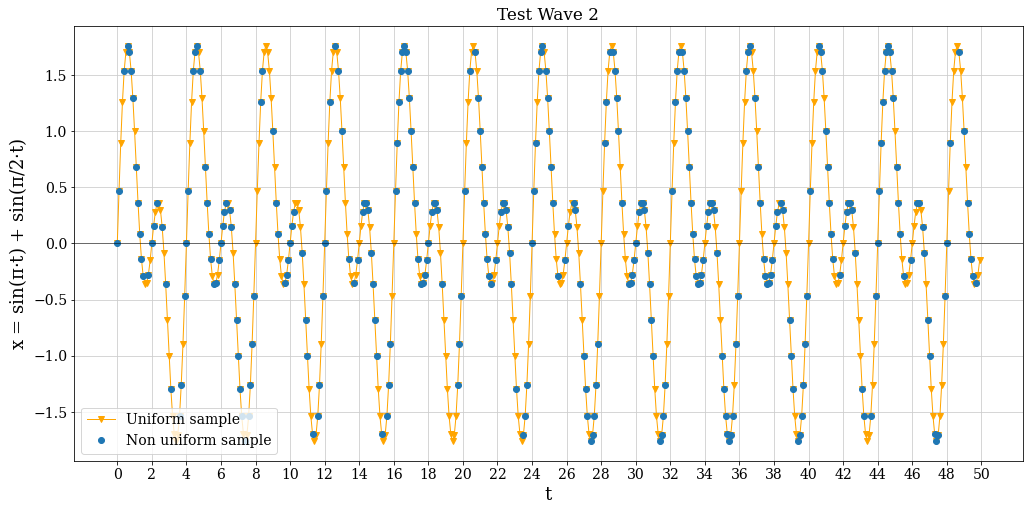

In [7]:
x3 = np.sin(np.pi*t)+np.sin(0.5*np.pi*t); x4 = x3[t2]# Periodos: 2t y 4t
x33 = np.sin(np.pi*t)+2*np.sin(0.5*np.pi*t)

plt.subplots(figsize=(17, 8))
plt.plot(t, x3,'v-',linewidth=1,markersize=6,label='Uniform sample',color='orange')
plt.plot(t[t2],x4,'o',markersize=6,label='Non uniform sample')

plt.title('Test Wave 2');plt.xlabel('t',fontsize=18);plt.ylabel('x = sin(\u03C0'+r'$\cdot$'+'t) + sin(\u03C0/2'+r'$\cdot$'+'t)',fontsize=18)
plt.grid(True, which='both',color='0.8');
plt.axhline(y=0, color='k',linewidth=0.5)
plt.legend()

x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-1-test wave2.pdf',bbox_inches='tight')

plt.show()

In [105]:
50/12

4.166666666666667

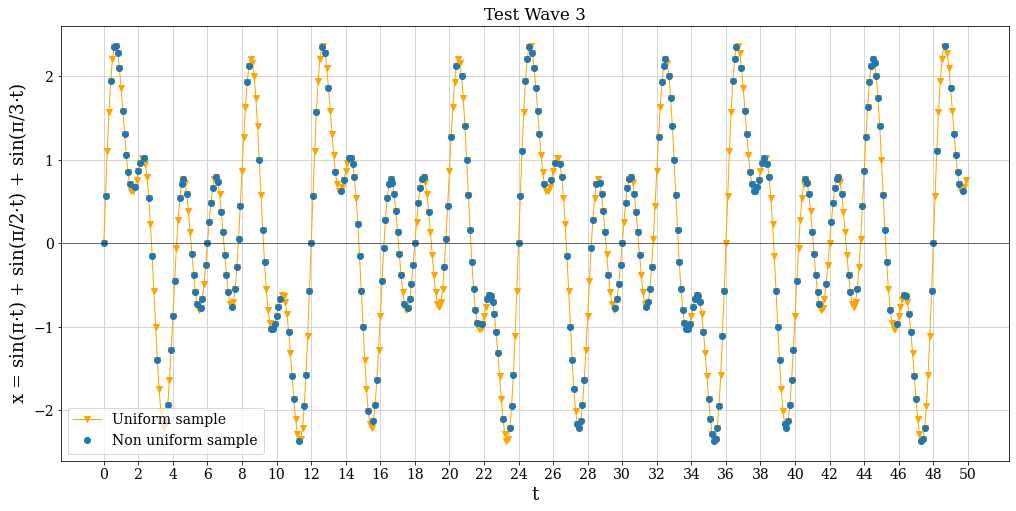

In [26]:
x5 = np.sin(np.pi*t)+np.sin(0.5*np.pi*t)+np.sin(np.pi*t/3); x6 = x5[t2]
x55 = np.sin(np.pi*t)+np.sin(0.5*np.pi*t)+2*np.sin(np.pi*t/3)

plt.subplots(figsize=(17, 8))
plt.plot(t, x5,'v-',linewidth=1,markersize=6,label='Uniform sample',color='orange')
plt.plot(t[t2],x6,'o',markersize=6,label='Non uniform sample')

plt.title('Test Wave 3');plt.xlabel('t',fontsize=18);plt.ylabel('x = sin(\u03C0'+r'$\cdot$'+'t) + sin(\u03C0/2'+r'$\cdot$'+'t) + sin(\u03C0/3'+r'$\cdot$'+'t)',fontsize=18)
plt.grid(True, which='both',color='0.8');
plt.axhline(y=0, color='k',linewidth=0.5)
plt.legend()
x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-1-test wave3.pdf',bbox_inches='tight')

plt.show()

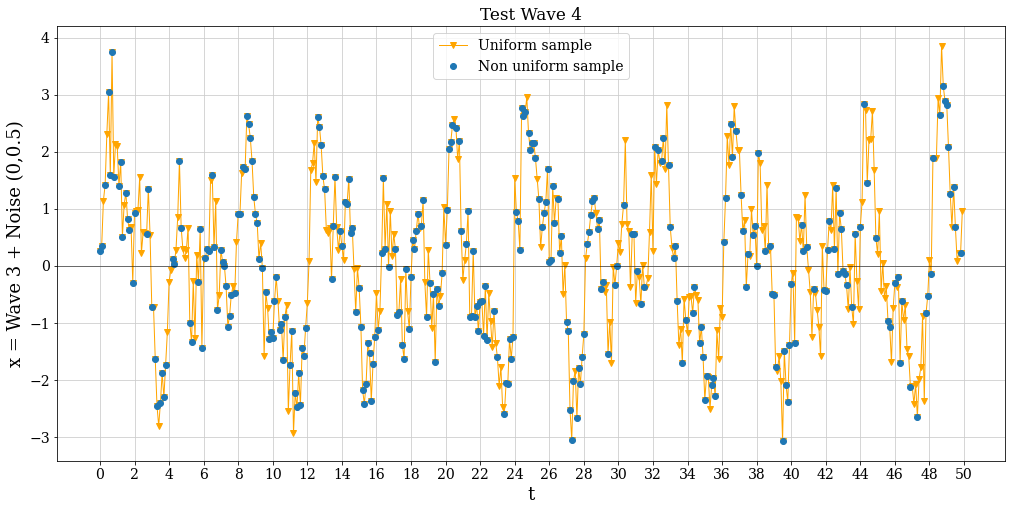

In [112]:
#x7 = np.sin(np.pi*t)+np.sin(0.5*np.pi*t)+np.sin(np.pi*t/3); 
#noise = np.random.normal(0,0.5,500); x7=x7+noise
#x8 = x7[t2]


plt.subplots(figsize=(17, 8))
plt.plot(t, x7,'v-',linewidth=1,markersize=6,label='Uniform sample',color='orange')
plt.plot(t[t2],x8,'o',markersize=6,label='Non uniform sample')

plt.title('Test Wave 4');plt.xlabel('t',fontsize=18);plt.ylabel('x = Wave 3 + Noise (0,0.5)',fontsize=18)
plt.grid(True, which='both',color='0.8');
plt.axhline(y=0, color='k',linewidth=0.5)
plt.legend()
x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-1-test wave4.pdf',bbox_inches='tight')

plt.show()

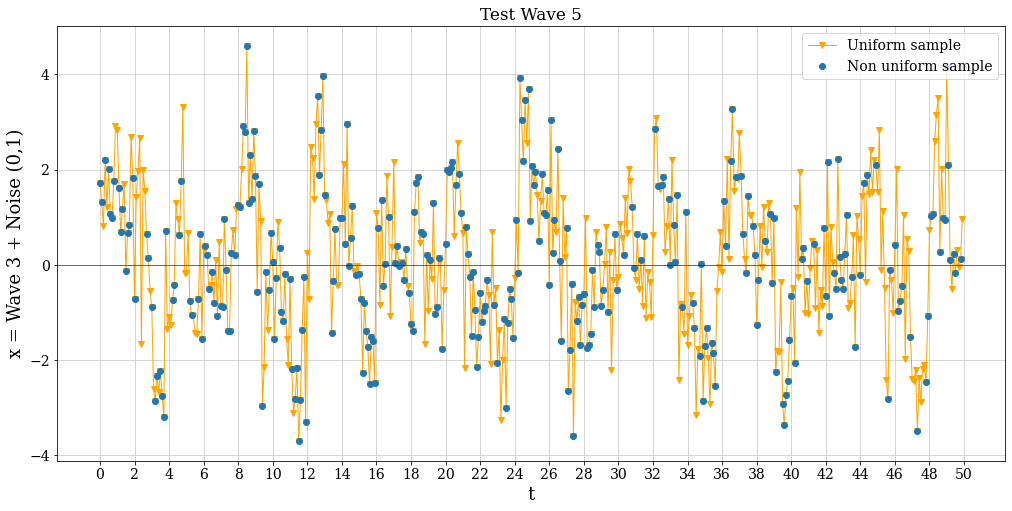

In [113]:
x9 = np.sin(np.pi*t)+np.sin(0.5*np.pi*t)+np.sin(np.pi*t/3)
noise2 = np.random.normal(0,1,500); 
x9=x9+noise2
x10 = x9[t2]


plt.subplots(figsize=(17, 8))
plt.plot(t, x9,'v-',linewidth=1,markersize=6,label='Uniform sample',color='orange')
plt.plot(t[t2],x10,'o',markersize=6,label='Non uniform sample')

plt.title('Test Wave 5');plt.xlabel('t',fontsize=18);plt.ylabel('x = Wave 3 + Noise (0,1)',fontsize=18)
plt.grid(True, which='both',color='0.8');
plt.axhline(y=0, color='k',linewidth=0.5)
plt.legend()
x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-1-test wave5.pdf',bbox_inches='tight')

plt.show()

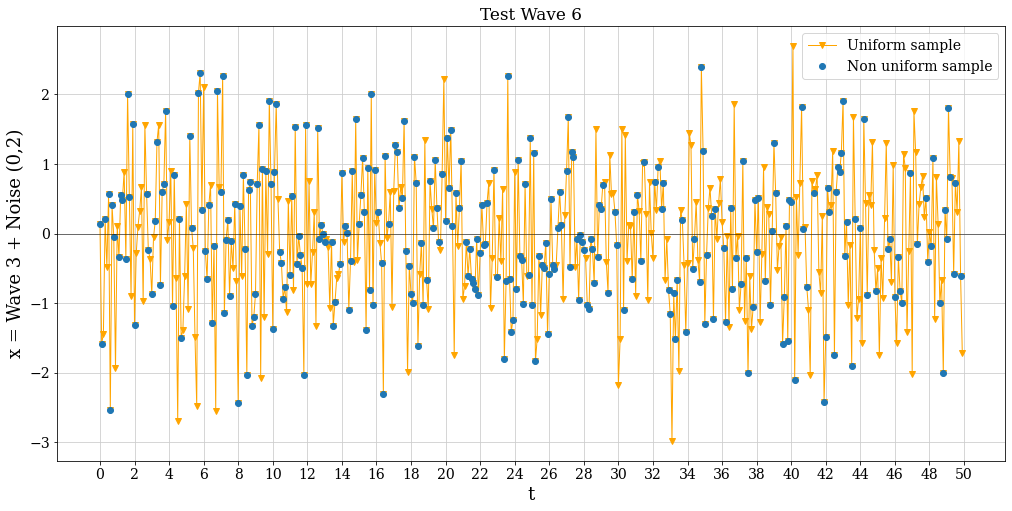

In [114]:
x11 = np.sin(np.pi*t)+np.sin(0.5*np.pi*t)+np.sin(np.pi*t/3)
noise3 = np.random.normal(0,1,500); 
x11=+noise3
x12 = x11[t2]

plt.subplots(figsize=(17, 8))
plt.plot(t, x11,'v-',linewidth=1,markersize=6,label='Uniform sample',color='orange')
plt.plot(t[t2],x12,'o',markersize=6,label='Non uniform sample')

plt.title('Test Wave 6');plt.xlabel('t',fontsize=18);plt.ylabel('x = Wave 3 + Noise (0,2)',fontsize=18)
plt.grid(True, which='both',color='0.8');
plt.axhline(y=0, color='k',linewidth=0.5)
plt.legend()
x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-1-test wave6.pdf',bbox_inches='tight')

plt.show()

In [79]:
[uni_delta_t1,uni_hs1,uni_time1,uni_amp1,uni_app1,uni_low1]=Haar(t,x)
[no_uni_delta_t1,no_uni_hs1,no_uni_time1,no_uni_amp1,no_uni_app1,no_uni_low1]=Haar(t[t2],x2)

t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 299
deltas_t steps: from 1 to 150
epsilons steps: 150
71  fluctuaciones eliminadas ( 0.321966261563577 %)
Min t:  -0.6989700043360281   Max t:  1.69284691927723


In [80]:
[uni_delta_t2,uni_hs2,uni_time2,uni_amp2,uni_app2,uni_low2]=Haar(t,x3)
[no_uni_delta_t2,no_uni_hs2,no_uni_time2,no_uni_amp2,no_uni_app2,no_uni_low2]=Haar(t[t2],x4)

t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 299
deltas_t steps: from 1 to 150
epsilons steps: 150
71  fluctuaciones eliminadas ( 0.321966261563577 %)
Min t:  -0.6989700043360281   Max t:  1.69284691927723


In [44]:
[uni_delta_t3,uni_hs3,uni_time3,uni_amp3,uni_app3,uni_low3]=Haar(t,x5)
[no_uni_delta_t3,no_uni_hs3,no_uni_time3,no_uni_amp3,no_uni_app3,no_uni_low3]=Haar(t[t2],x6)

t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 299
deltas_t steps: from 1 to 150
epsilons steps: 150
75  fluctuaciones eliminadas ( 0.340105205877018 %)
Min t:  -0.6989700043360281   Max t:  1.69284691927723


In [82]:
[uni_delta_t4,uni_hs4,uni_time4,uni_amp4,uni_app4,uni_low4]=Haar(t,x7)
[no_uni_delta_t4,no_uni_hs4,no_uni_time4,no_uni_amp4,no_uni_app4,no_uni_low4]=Haar(t[t2],x8)

t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 299
deltas_t steps: from 1 to 150
epsilons steps: 150
71  fluctuaciones eliminadas ( 0.321966261563577 %)
Min t:  -0.6989700043360281   Max t:  1.69284691927723


In [83]:
[uni_delta_t5,uni_hs5,uni_time5,uni_amp5,uni_app5,uni_low5]=Haar(t,x9)
[no_uni_delta_t5,no_uni_hs5,no_uni_time5,no_uni_amp5,no_uni_app5,no_uni_low5]=Haar(t[t2],x10)

t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 299
deltas_t steps: from 1 to 150
epsilons steps: 150
71  fluctuaciones eliminadas ( 0.321966261563577 %)
Min t:  -0.6989700043360281   Max t:  1.69284691927723


In [84]:
[uni_delta_t6,uni_hs6,uni_time6,uni_amp6,uni_app6,uni_low6]=Haar(t,x11)
[no_uni_delta_t6,no_uni_hs6,no_uni_time6,no_uni_amp6,no_uni_app6,no_uni_low6]=Haar(t[t2],x12)

t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 299
deltas_t steps: from 1 to 150
epsilons steps: 150
71  fluctuaciones eliminadas ( 0.321966261563577 %)
Min t:  -0.6989700043360281   Max t:  1.69284691927723


In [38]:
#[uni_delta_t1,uni_hs1,uni_time1,uni_amp1,uni_app1,uni_low1]=Haar(t,x)
#[uni_delta_t2,uni_hs2,uni_time2,uni_amp2,uni_app2,uni_low2]=Haar(t,2*x) #2sin(pi*t)
#[uni_delta_t3,uni_hs3,uni_time3,uni_amp3,uni_app3,uni_low3]=Haar(t,x3)
#[uni_delta_t4,uni_hs4,uni_time4,uni_amp4,uni_app4,uni_low4]=Haar(t,x33) #sin(pi*t) +2sin(pit/2)
[uni_delta_t5,uni_hs5,uni_time5,uni_amp5,uni_app5,uni_low5]=Haar(t,x5)
[uni_delta_t6,uni_hs6,uni_time6,uni_amp6,uni_app6,uni_low6]=Haar(t,x55) #sin(pi*t) +sin(pit/2) + 2sin(pi/3)

t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974


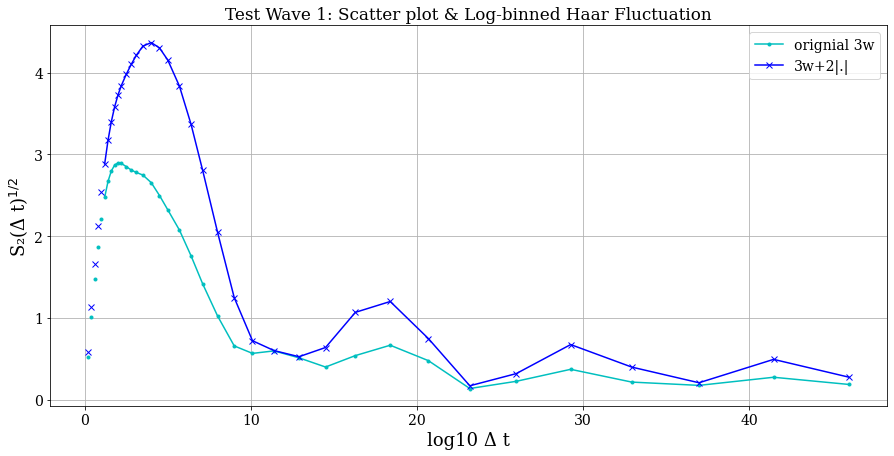

In [173]:
plt.subplots(figsize=(15, 7))
#plt.plot(uni_delta_t6,np.sqrt(uni_hs6),'.',color='blue')
#plt.plot(uni_delta_t5,np.sqrt(uni_hs5),'.',color='orange')
plt.plot(10**uni_time5,uni_amp5,'.-',color='c',label='orignial 3w')
plt.plot(10**uni_time6,uni_amp6,'x-',color='b',label='3w+2|.|')

#plt.plot(uni_delta_t4,np.sqrt(uni_hs4),'.',color='orange')
#plt.plot(uni_delta_t3,np.sqrt(uni_hs3),'.',color='y')
#plt.plot(10**uni_time3,uni_amp3,'.-',color='g',label='orignial 2w')
#plt.plot(10**uni_time4,uni_amp4,'x-',color='orange',label='2w+2|.|')

plt.legend()
plt.title('Test Wave 1: Scatter plot & Log-binned Haar Fluctuation')
plt.xlabel('log10 \u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
#x_ticks  = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
#x_labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
#plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.axvline(x=np.log10(4))
#plt.axvline(x=np.log10(12))
#plt.axvline(x=np.log10(18))
#plt.axvline(x=np.log10(24))

plt.grid(alpha=1)
#plt.savefig('12-SinteticA1-2-2 scatter-log Wave1.pdf',bbox_inches='tight')
plt.show()

In [41]:
#periodos 2,4,6-> gran periodo = 12
#debería tener max en 4, minimo en 12, max en 18, min en 24
print(np.log10(4),np.log10(12),np.log10(18),np.log10(24))
print(18/12)
print(2/12)
print(4/12)

0.6020599913279624 1.0791812460476249 1.255272505103306 1.380211241711606
1.5
0.16666666666666666
0.3333333333333333


In [27]:
2/40

0.05

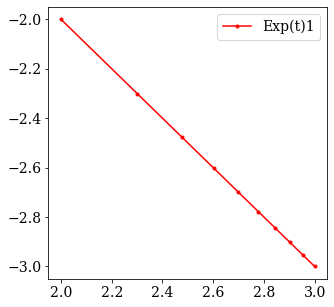

In [26]:
x=np.array([1,2,3,4,5,6,7,8,9,10])*100
y=np.array([])
#y=np.copy(x)
for i in x:
    y=np.append(y,1/(i))
plt.subplots(figsize=(5, 5))
plt.plot(np.log10(x),np.log10(y),'.-',color='red',label='Exp(t)1')
#plt.savefig('exponential.jpg',bbox_inches='tight')
plt.legend()
plt.show()

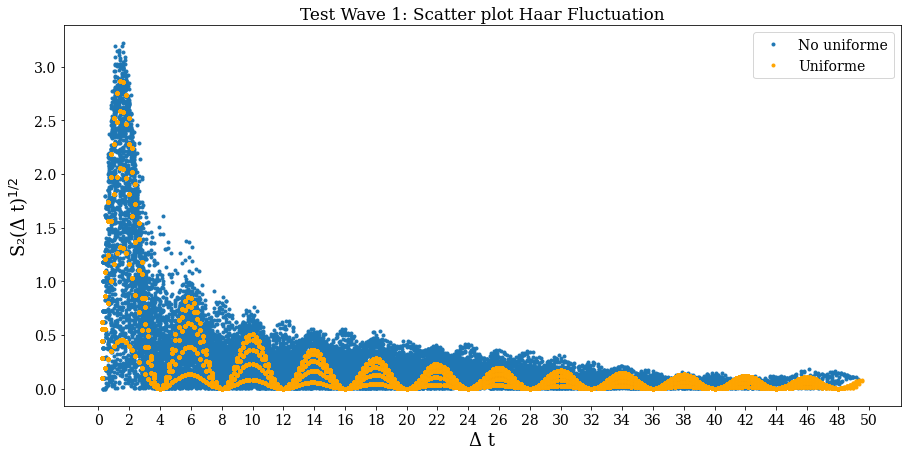

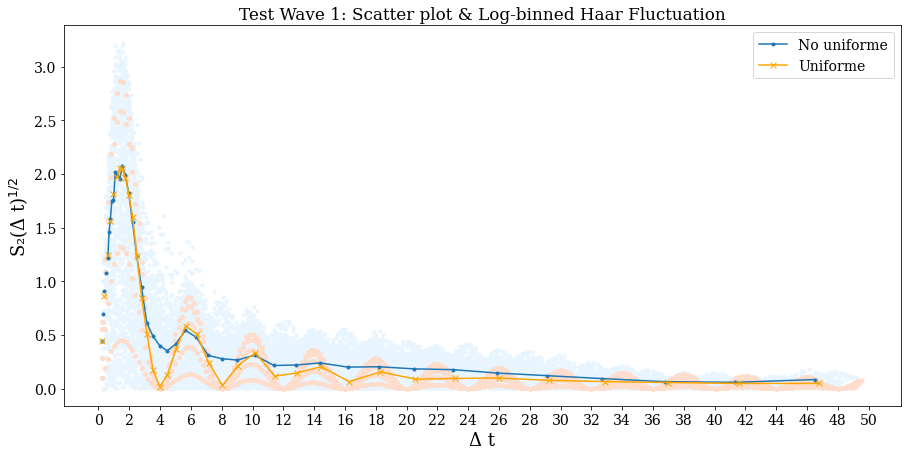

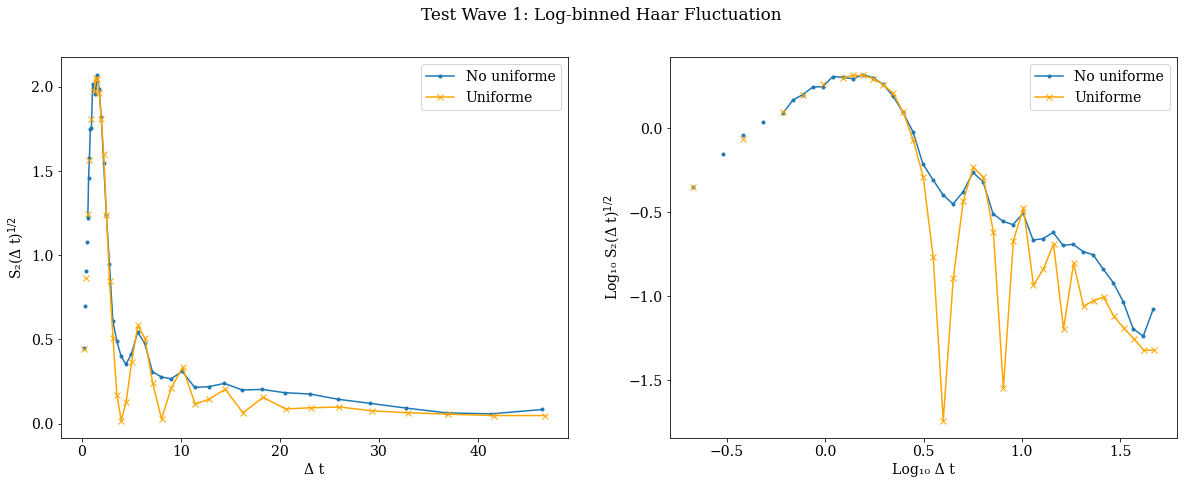

In [102]:
############ Test Wave 1 ##################

plt.subplots(figsize=(15, 7))
plt.plot(no_uni_delta_t1,np.sqrt(no_uni_hs1),'.',label='No uniforme')
plt.plot(uni_delta_t1,np.sqrt(uni_hs1),'.',color='orange',label='Uniforme')
plt.legend()
plt.title('Test Wave 1: Scatter plot Haar Fluctuation')
plt.xlabel('\u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
#plt.axvline(x=2,linestyle='--',color='black',linewidth=0.7)

x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-2-1 scatter Wave1.pdf',bbox_inches='tight')
plt.show()


plt.subplots(figsize=(15, 7))
plt.plot(no_uni_delta_t1,np.sqrt(no_uni_hs1),'.',color='#E8F5FF')
plt.plot(uni_delta_t1,np.sqrt(uni_hs1),'.',color='#FFDDCD')
plt.plot(10**no_uni_time1,no_uni_amp1,'.-',label='No uniforme')
plt.plot(10**uni_time1,uni_amp1,'x-',color='orange',label='Uniforme')
plt.legend()
plt.title('Test Wave 1: Scatter plot & Log-binned Haar Fluctuation')
plt.xlabel('\u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-2-2 scatter-log Wave1.pdf',bbox_inches='tight')
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 7))
fig.suptitle('Test Wave 1: Log-binned Haar Fluctuation')
ax1.plot(10**no_uni_time1,no_uni_amp1,'.-',label='No uniforme')
ax1.plot(10**uni_time1,uni_amp1,'x-',color='orange',label='Uniforme')
ax1.set(xlabel='\u0394 t', ylabel='S\u2082(\u0394 t)'+r'$^{1/2}$')
ax1.legend()
ax2.plot(no_uni_time1,np.log10(no_uni_amp1),'.-',label='No uniforme')
ax2.plot(uni_time1,np.log10(uni_amp1),'x-',color='orange',label='Uniforme')
ax2.set(xlabel='Log\u2081\u2080 \u0394 t', ylabel='Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$')
ax2.legend()
#plt.savefig('12-SinteticA1-2-3 log-log Wave1.pdf',bbox_inches='tight')
plt.show()


#plt.subplots(figsize=(15, 7))
#plt.plot(no_uni_time1,(no_uni_amp1),'.-',label='No uniforme')
#plt.plot(no_uni_time1,(no_uni_app1),'--',color='c',label='NU Std()',linewidth=0.5);plt.plot(no_uni_time1,(no_uni_low1),'--',color='c',linewidth=0.5)
#plt.plot(uni_time1,(uni_amp1),'x-',color='orange',label='Uniforme')
#plt.plot(uni_time1,(uni_app1),'--',color='red',label='U Std()',linewidth=0.5);plt.plot(uni_time1,(uni_low1),'--',color='red',linewidth=0.5)
#plt.title('Test Wave 1 Haar Fluctuation');plt.legend()
#plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
#plt.savefig('1-line+std Test Wave 1.jpg',bbox_inches='tight')
#plt.show()

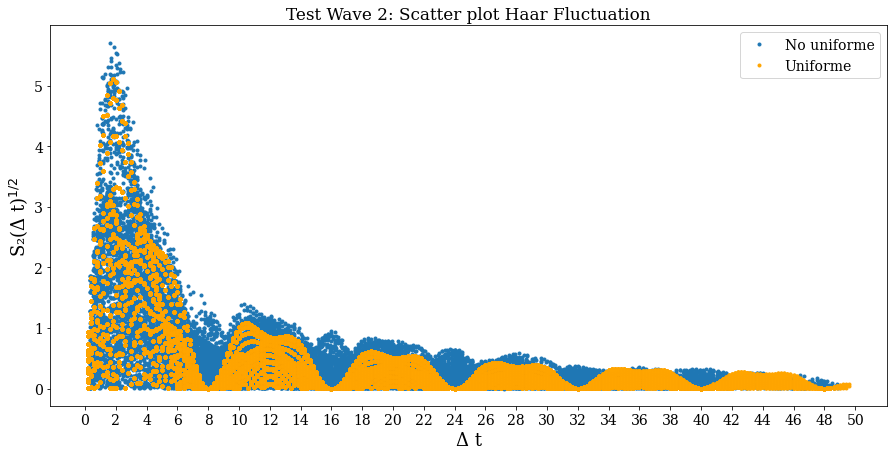

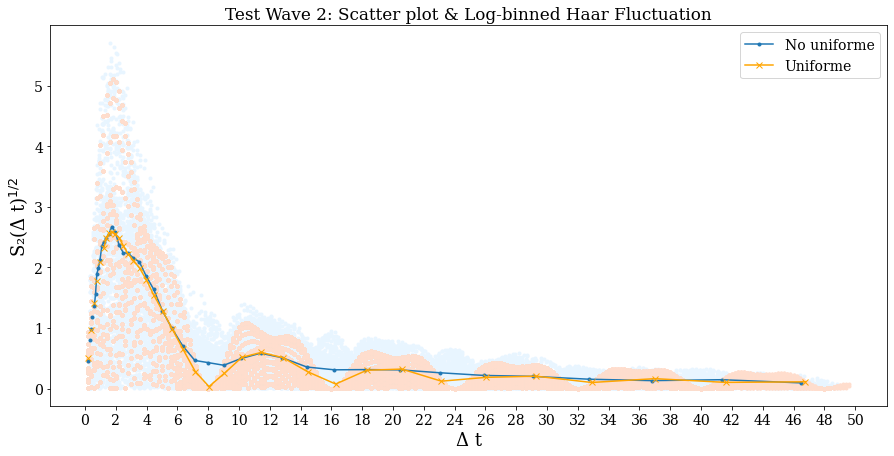

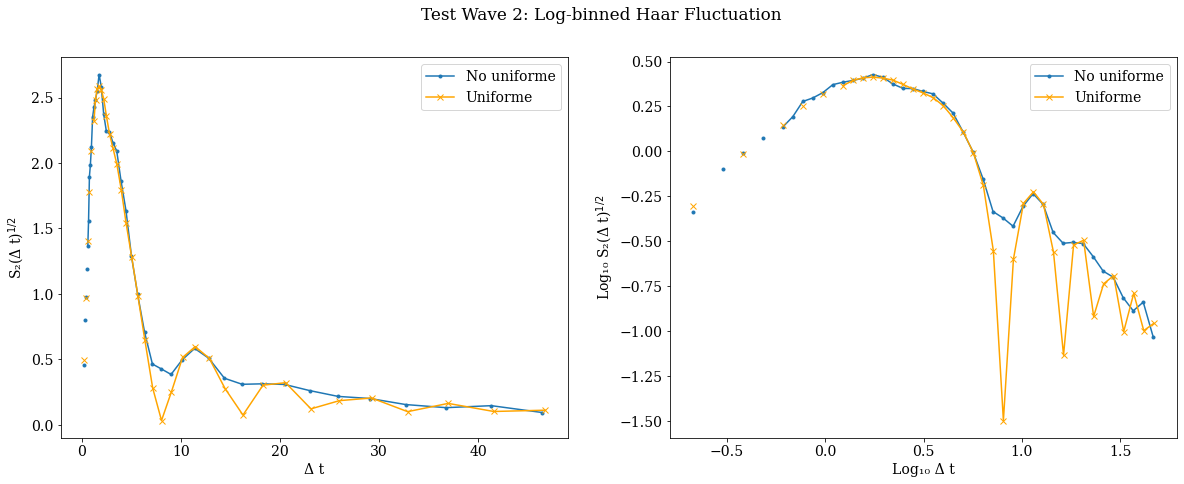

In [116]:
############ WAVE 2 ##################

plt.subplots(figsize=(15, 7))
#plt.plot(no_uni_delta_t1,np.sqrt(no_uni_hs1),'.',color='green',label='No uniforme1')
plt.plot(no_uni_delta_t2,np.sqrt(no_uni_hs2),'.',label='No uniforme')
plt.plot(uni_delta_t2,np.sqrt(uni_hs2),'.',color='orange',label='Uniforme')
plt.legend()
plt.title('Test Wave 2: Scatter plot Haar Fluctuation')
plt.xlabel('\u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-2-1 scatter Wave2.pdf',bbox_inches='tight')
plt.show()


plt.subplots(figsize=(15, 7))
plt.plot(no_uni_delta_t2,np.sqrt(no_uni_hs2),'.',color='#E8F5FF')
plt.plot(uni_delta_t2,np.sqrt(uni_hs2),'.',color='#FFDDCD')
plt.plot(10**no_uni_time2,no_uni_amp2,'.-',label='No uniforme')
plt.plot(10**uni_time2,uni_amp2,'x-',color='orange',label='Uniforme')
plt.legend()
plt.title('Test Wave 2: Scatter plot & Log-binned Haar Fluctuation')
plt.xlabel('\u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-2-2 scatter-log Wave2.pdf',bbox_inches='tight')
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 7))
fig.suptitle('Test Wave 2: Log-binned Haar Fluctuation')
#ax1.plot(10**no_uni_time1,no_uni_amp1,'.-',color='green',label='No uniforme1')
ax1.plot(10**no_uni_time2,no_uni_amp2,'.-',label='No uniforme')
ax1.plot(10**uni_time2,uni_amp2,'x-',color='orange',label='Uniforme')
ax1.set(xlabel='\u0394 t', ylabel='S\u2082(\u0394 t)'+r'$^{1/2}$')
ax1.legend()
ax2.plot(no_uni_time2,np.log10(no_uni_amp2),'.-',label='No uniforme')
ax2.plot(uni_time2,np.log10(uni_amp2),'x-',color='orange',label='Uniforme')
ax2.set(xlabel='Log\u2081\u2080 \u0394 t', ylabel='Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$')
ax2.legend()
#plt.savefig('12-SinteticA1-2-3 log-log Wave2.pdf',bbox_inches='tight')
plt.show()


#plt.subplots(figsize=(15, 7))
#plt.plot(no_uni_time2,(no_uni_amp2),'.-',label='No uniforme')
#plt.plot(no_uni_time2,(no_uni_app2),'--',color='c',label='NU Std()',linewidth=0.5);
#plt.plot(no_uni_time2,(no_uni_low2),'--',color='c',linewidth=0.5)
#plt.plot(uni_time2,(uni_amp2),'x-',color='orange',label='Uniforme')
#plt.plot(uni_time2,(uni_app2),'--',color='red',label='U Std()',linewidth=0.5);
#plt.plot(uni_time2,(uni_low2),'--',color='red',linewidth=0.5)
#plt.title('Wave 2 Haar Fluctuation');plt.legend()
#plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
#plt.savefig('2-line+std Wave 2.jpg',bbox_inches='tight')
#plt.show()

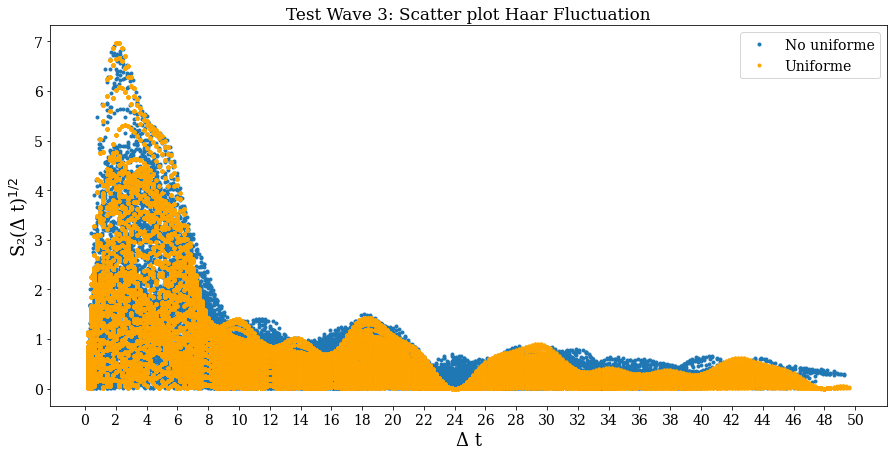

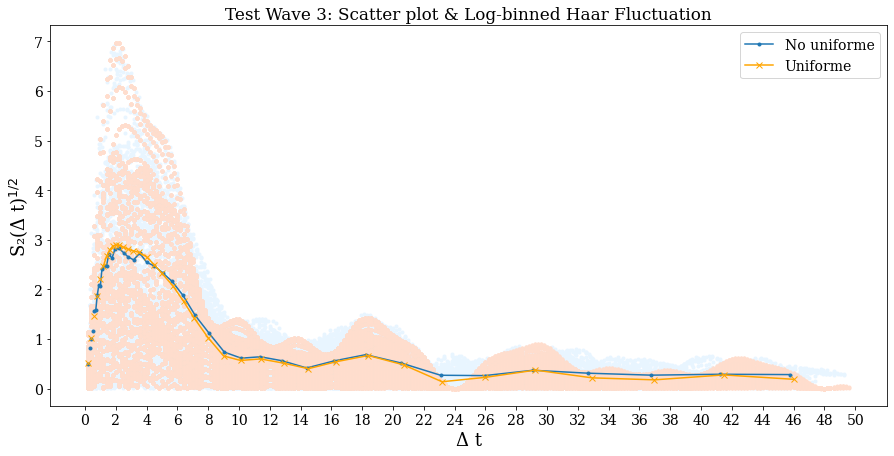

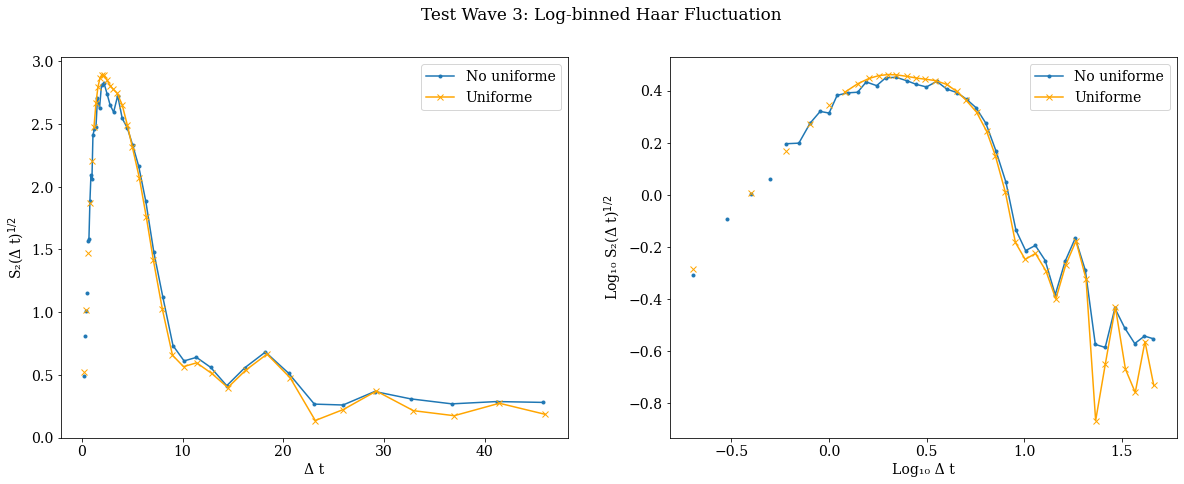

In [45]:
############ WAVE 3 ##################

plt.subplots(figsize=(15, 7))
plt.plot(no_uni_delta_t3,np.sqrt(no_uni_hs3),'.',label='No uniforme')
plt.plot(uni_delta_t3,np.sqrt(uni_hs3),'.',color='orange',label='Uniforme')
plt.legend()
plt.title('Test Wave 3: Scatter plot Haar Fluctuation')
plt.xlabel('\u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)

x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-2-1 scatter Wave3.pdf',bbox_inches='tight')
plt.show()


plt.subplots(figsize=(15, 7))
plt.plot(no_uni_delta_t3,np.sqrt(no_uni_hs3),'.',color='#E8F5FF')
plt.plot(uni_delta_t3,np.sqrt(uni_hs3),'.',color='#FFDDCD')
plt.plot(10**no_uni_time3,no_uni_amp3,'.-',label='No uniforme')
plt.plot(10**uni_time3,uni_amp3,'x-',color='orange',label='Uniforme')
plt.legend()
plt.title('Test Wave 3: Scatter plot & Log-binned Haar Fluctuation')
plt.xlabel('\u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)

x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-2-2 scatter-log Wave3.pdf',bbox_inches='tight')
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 7))
fig.suptitle('Test Wave 3: Log-binned Haar Fluctuation')
ax1.plot(10**no_uni_time3,no_uni_amp3,'.-',label='No uniforme')
ax1.plot(10**uni_time3,uni_amp3,'x-',color='orange',label='Uniforme')
ax1.set(xlabel='\u0394 t', ylabel='S\u2082(\u0394 t)'+r'$^{1/2}$')
ax1.legend()
ax2.plot(no_uni_time3,np.log10(no_uni_amp3),'.-',label='No uniforme')
ax2.plot(uni_time3,np.log10(uni_amp3),'x-',color='orange',label='Uniforme')
ax2.set(xlabel='Log\u2081\u2080 \u0394 t', ylabel='Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$')
ax2.legend()

#plt.savefig('12-SinteticA1-2-3 log-log Wave3.pdf',bbox_inches='tight')
plt.show()


#plt.subplots(figsize=(15, 7))
#plt.plot(no_uni_time3,(no_uni_amp3),'.-',label='No uniforme')
#plt.plot(no_uni_time3,(no_uni_app3),'--',color='c',label='NU Std()',linewidth=0.5);
#plt.plot(no_uni_time3,(no_uni_low3),'--',color='c',linewidth=0.5)
#plt.plot(uni_time3,(uni_amp3),'x-',color='orange',label='Uniforme')
#plt.plot(uni_time3,(uni_app3),'--',color='red',label='U Std()',linewidth=0.5);
#plt.plot(uni_time3,(uni_low3),'--',color='red',linewidth=0.5)
#plt.title('Wave 3 Haar Fluctuation');plt.legend()
#plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
#plt.savefig('3-line+std Wave 3.jpg',bbox_inches='tight')
#plt.show()

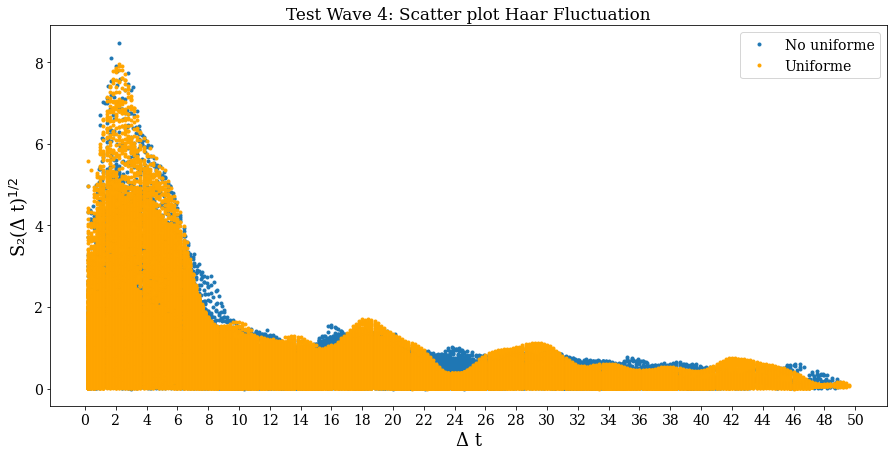

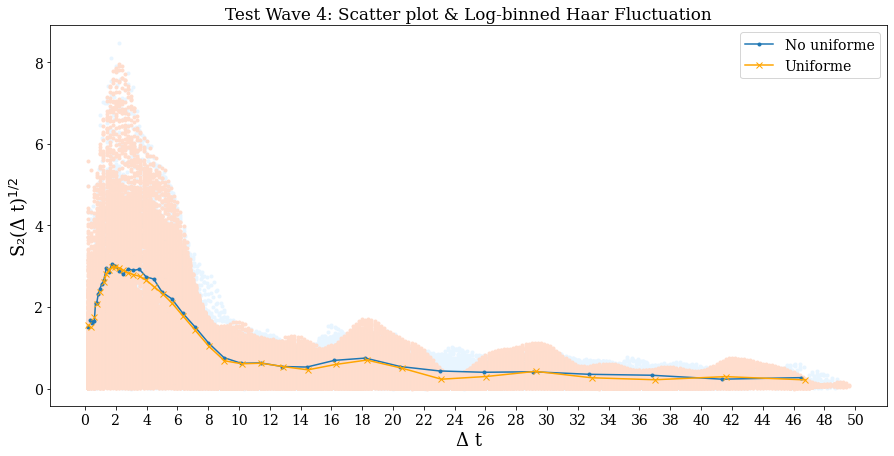

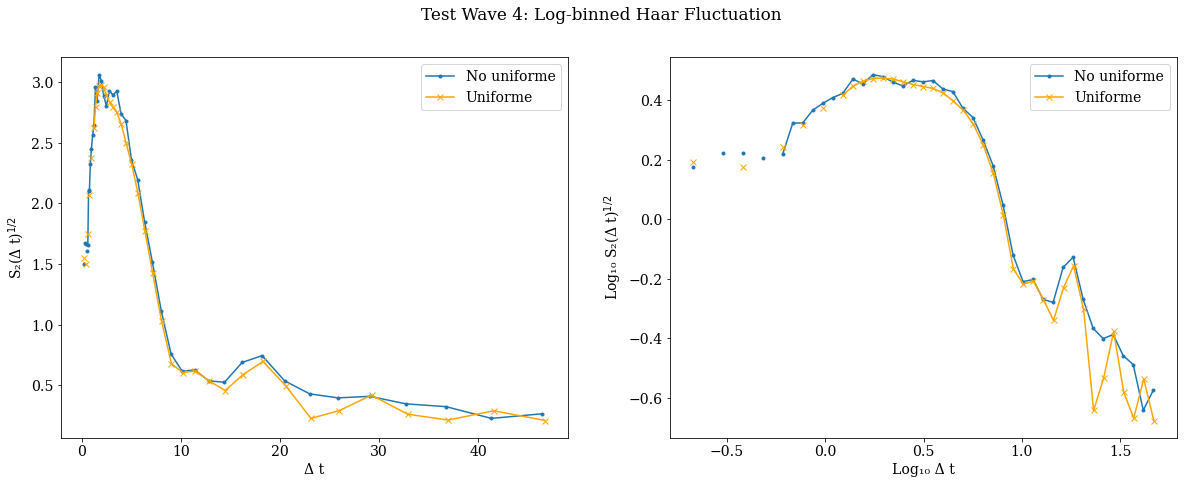

In [122]:
############ WAVE 4 ##################

plt.subplots(figsize=(15, 7))
plt.plot(no_uni_delta_t4,np.sqrt(no_uni_hs4),'.',label='No uniforme')
plt.plot(uni_delta_t4,np.sqrt(uni_hs4),'.',color='orange',label='Uniforme')
plt.legend()
plt.title('Test Wave 4: Scatter plot Haar Fluctuation')
plt.xlabel('\u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)

x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-2-1 scatter Wave4.pdf',bbox_inches='tight')
plt.show()


plt.subplots(figsize=(15, 7))
plt.plot(no_uni_delta_t4,np.sqrt(no_uni_hs4),'.',color='#E8F5FF')
plt.plot(uni_delta_t4,np.sqrt(uni_hs4),'.',color='#FFDDCD')
plt.plot(10**no_uni_time4,no_uni_amp4,'.-',label='No uniforme')
plt.plot(10**uni_time4,uni_amp4,'x-',color='orange',label='Uniforme')
plt.legend()
plt.title('Test Wave 4: Scatter plot & Log-binned Haar Fluctuation')
plt.xlabel('\u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)

x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-2-2 scatter-log Wave4.pdf',bbox_inches='tight')
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 7))
fig.suptitle('Test Wave 4: Log-binned Haar Fluctuation')
ax1.plot(10**no_uni_time4,no_uni_amp4,'.-',label='No uniforme')
ax1.plot(10**uni_time4,uni_amp4,'x-',color='orange',label='Uniforme')
ax1.set(xlabel='\u0394 t', ylabel='S\u2082(\u0394 t)'+r'$^{1/2}$')
ax1.legend()
ax2.plot(no_uni_time4,np.log10(no_uni_amp4),'.-',label='No uniforme')
ax2.plot(uni_time4,np.log10(uni_amp4),'x-',color='orange',label='Uniforme')
ax2.set(xlabel='Log\u2081\u2080 \u0394 t', ylabel='Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$')
ax2.legend()
#plt.savefig('12-SinteticA1-2-3 log-log Wave4.pdf',bbox_inches='tight')
plt.show()


#plt.subplots(figsize=(15, 7))
#plt.plot(no_uni_time4,(no_uni_amp4),'.-',label='No uniforme')
#plt.plot(no_uni_time4,(no_uni_app4),'--',color='c',label='NU Std()',linewidth=0.5);
#plt.plot(no_uni_time4,(no_uni_low4),'--',color='c',linewidth=0.5)
#plt.plot(uni_time4,(uni_amp4),'x-',color='orange',label='Uniforme')
#plt.plot(uni_time4,(uni_app4),'--',color='red',label='U Std()',linewidth=0.5);
#plt.plot(uni_time4,(uni_low4),'--',color='red',linewidth=0.5)
#plt.title('Wave 4 Haar Fluctuation');plt.legend()
#plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
#plt.savefig('4-line+std Wave 4.jpg',bbox_inches='tight')
#plt.show()

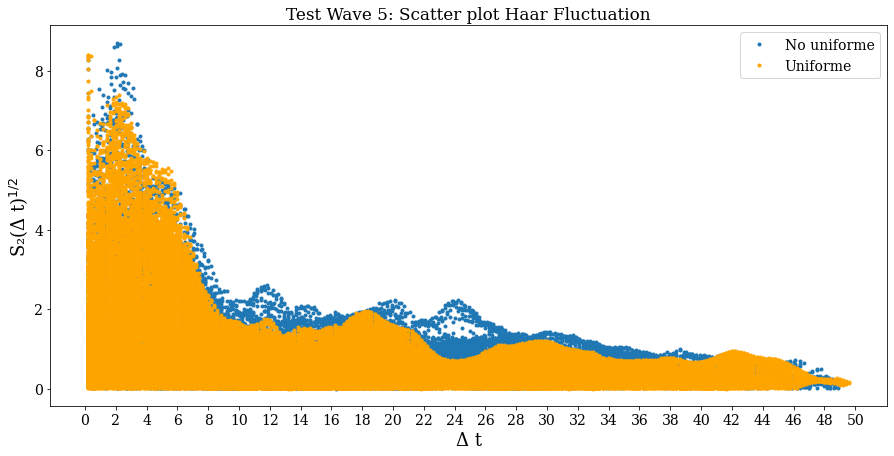

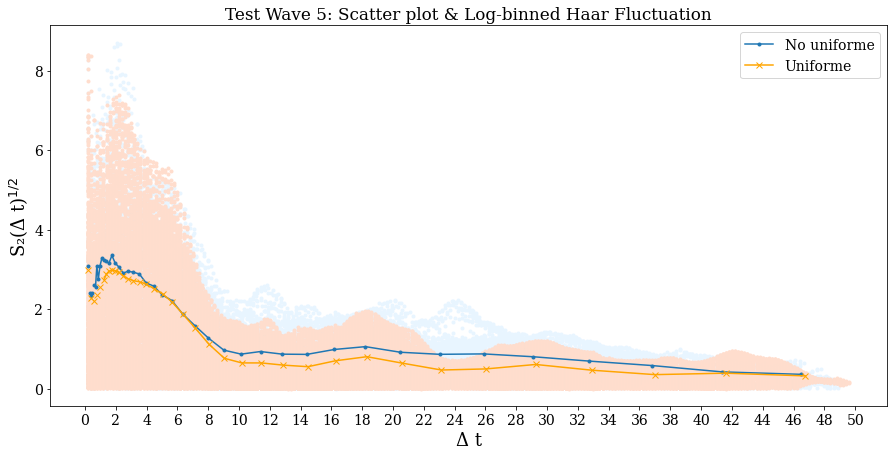

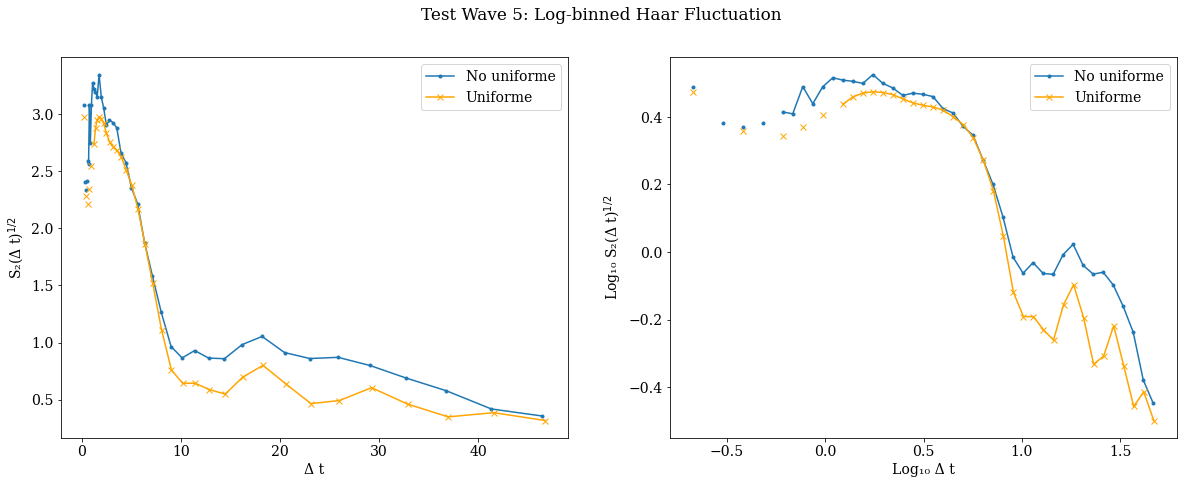

In [124]:
############ WAVE 5 ##################

plt.subplots(figsize=(15, 7))
plt.plot(no_uni_delta_t5,np.sqrt(no_uni_hs5),'.',label='No uniforme')
plt.plot(uni_delta_t5,np.sqrt(uni_hs5),'.',color='orange',label='Uniforme')
plt.legend()
plt.title('Test Wave 5: Scatter plot Haar Fluctuation')
plt.xlabel('\u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-2-1 scatter Wave5.pdf',bbox_inches='tight')
plt.show()


plt.subplots(figsize=(15, 7))
plt.plot(no_uni_delta_t5,np.sqrt(no_uni_hs5),'.',color='#E8F5FF')
plt.plot(uni_delta_t5,np.sqrt(uni_hs5),'.',color='#FFDDCD')
plt.plot(10**no_uni_time5,no_uni_amp5,'.-',label='No uniforme')
plt.plot(10**uni_time5,uni_amp5,'x-',color='orange',label='Uniforme')
plt.legend()
plt.title('Test Wave 5: Scatter plot & Log-binned Haar Fluctuation')
plt.xlabel('\u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)

x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-2-2 scatter-log Wave5.pdf',bbox_inches='tight')
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 7))
fig.suptitle('Test Wave 5: Log-binned Haar Fluctuation')
ax1.plot(10**no_uni_time5,no_uni_amp5,'.-',label='No uniforme')
ax1.plot(10**uni_time5,uni_amp5,'x-',color='orange',label='Uniforme')
ax1.set(xlabel='\u0394 t', ylabel='S\u2082(\u0394 t)'+r'$^{1/2}$')
ax1.legend()
ax2.plot(no_uni_time5,np.log10(no_uni_amp5),'.-',label='No uniforme')
ax2.plot(uni_time5,np.log10(uni_amp5),'x-',color='orange',label='Uniforme')
ax2.set(xlabel='Log\u2081\u2080 \u0394 t', ylabel='Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$')
ax2.legend()
#plt.savefig('12-SinteticA1-2-3 log-log Wave5.pdf',bbox_inches='tight')
plt.show()


#plt.subplots(figsize=(15, 7))
#plt.plot(no_uni_time5,(no_uni_amp5),'.-',label='No uniforme')
#plt.plot(no_uni_time5,(no_uni_app5),'--',color='c',label='NU Std()',linewidth=0.5);
#plt.plot(no_uni_time5,(no_uni_low5),'--',color='c',linewidth=0.5)
#plt.plot(uni_time5,(uni_amp5),'x-',color='orange',label='Uniforme')
#plt.plot(uni_time5,(uni_app5),'--',color='red',label='U Std()',linewidth=0.5);
#plt.plot(uni_time5,(uni_low5),'--',color='red',linewidth=0.5)
#plt.title('Wave 5 Haar Fluctuation');plt.legend()
#plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
#plt.savefig('5-line+std Wave 5.jpg',bbox_inches='tight')
#plt.show()

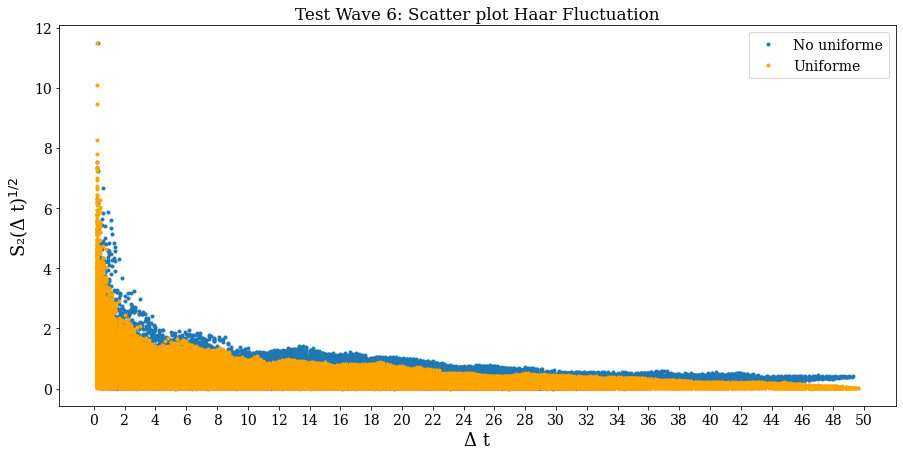

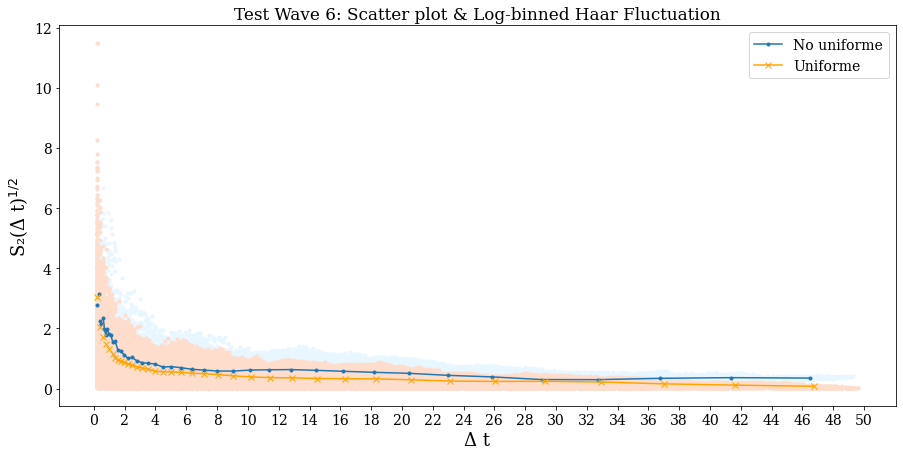

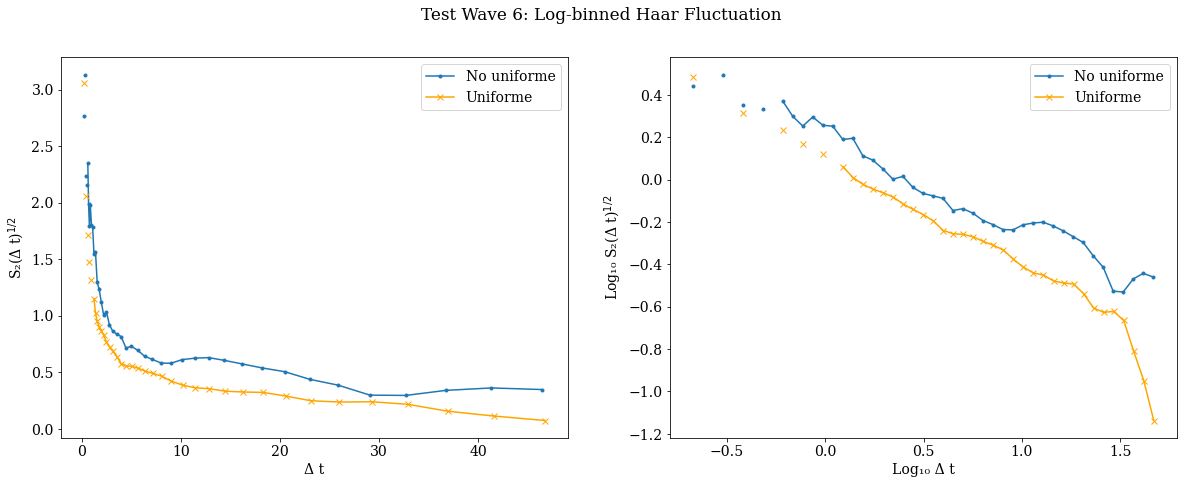

In [126]:
############ WAVE 6 ##################

plt.subplots(figsize=(15, 7))
plt.plot(no_uni_delta_t6,np.sqrt(no_uni_hs6),'.',label='No uniforme')
plt.plot(uni_delta_t6,np.sqrt(uni_hs6),'.',color='orange',label='Uniforme')
plt.legend()
plt.title('Test Wave 6: Scatter plot Haar Fluctuation')
plt.xlabel('\u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)

x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-2-1 scatter Wave6.pdf',bbox_inches='tight')
plt.show()


plt.subplots(figsize=(15, 7))
plt.plot(no_uni_delta_t6,np.sqrt(no_uni_hs6),'.',color='#E8F6FF')
plt.plot(uni_delta_t6,np.sqrt(uni_hs6),'.',color='#FFDDCD')
plt.plot(10**no_uni_time6,no_uni_amp6,'.-',label='No uniforme')
plt.plot(10**uni_time6,uni_amp6,'x-',color='orange',label='Uniforme')
plt.legend()
plt.title('Test Wave 6: Scatter plot & Log-binned Haar Fluctuation')
plt.xlabel('\u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)

x_ticks  = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
x_labels = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,42,44,46,48,50]
plt.xticks(ticks=x_ticks, labels=x_labels)

#plt.savefig('12-SinteticA1-2-2 scatter-log Wave6.pdf',bbox_inches='tight')
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20, 7))
fig.suptitle('Test Wave 6: Log-binned Haar Fluctuation')
ax1.plot(10**no_uni_time6,no_uni_amp6,'.-',label='No uniforme')
ax1.plot(10**uni_time6,uni_amp6,'x-',color='orange',label='Uniforme')
ax1.set(xlabel='\u0394 t', ylabel='S\u2082(\u0394 t)'+r'$^{1/2}$')
ax1.legend()
ax2.plot(no_uni_time6,np.log10(no_uni_amp6),'.-',label='No uniforme')
ax2.plot(uni_time6,np.log10(uni_amp6),'x-',color='orange',label='Uniforme')
ax2.set(xlabel='Log\u2081\u2080 \u0394 t', ylabel='Log\u2081\u2080 S\u2082(\u0394 t)'+r'$^{1/2}$')
ax2.legend()
#plt.savefig('12-SinteticA1-2-3 log-log Wave6.pdf',bbox_inches='tight')
plt.show()


#plt.subplots(figsize=(15, 7))
#plt.plot(no_uni_time6,(no_uni_amp6),'.-',label='No uniforme')
#plt.plot(no_uni_time6,(no_uni_app6),'--',color='c',label='NU Std()',linewidth=0.5);
#plt.plot(no_uni_time6,(no_uni_low6),'--',color='c',linewidth=0.5)
#plt.plot(uni_time6,(uni_amp6),'x-',color='orange',label='Uniforme')
#plt.plot(uni_time6,(uni_app6),'--',color='red',label='U Std()',linewidth=0.5);
#plt.plot(uni_time6,(uni_low6),'--',color='red',linewidth=0.5)
#plt.title('Wave 6 Haar Fluctuation');plt.legend()
#plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);plt.ylabel('S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
#plt.savefig('6-line+std Wave 6.jpg',bbox_inches='tight')
#plt.show()

### Signal to noise ratio

In [34]:
#https://pysdr.org/content/noise.html
# SNR= VAR(signal)/VAR(noise)


In [46]:
base_wave=np.copy(x5)
#n1 = np.random.normal(0,1,500);
#n2 = np.random.normal(0,1,500);
#n3 = np.random.normal(0,1.5,500);
#n4 = np.random.normal(0,1.25,500);

SNR1=np.round(np.var(base_wave)/np.var(n1),2)
SNR2=np.round(np.var(base_wave)/np.var(n2),2)
SNR3=np.round(np.var(base_wave)/np.var(n3),2)
SNR4=np.round(np.var(base_wave)/np.var(n4),2)
print('SNR n1: ',SNR1)
print('SNR n2: ',SNR2)
print('SNR n3: ',SNR3)
print('SNR n4: ',SNR4)

SNR n1:  1.45
SNR n2:  1.55
SNR n3:  0.63
SNR n4:  0.97


In [47]:
#n5 = np.random.normal(0,1,500);
#n6 = np.random.normal(0,1,500);
#n7 = np.random.normal(0,2,500);
#n8 = np.random.normal(0,2,500);

SNR5=np.round(np.var(base_wave)/np.var(n5),2)
SNR6=np.round(np.var(base_wave)/np.var(n6),2)
SNR7=np.round(np.var(base_wave)/np.var(n7),2)
SNR8=np.round(np.var(base_wave)/np.var(n8),2)
print('SNR n5: ',SNR5)
print('SNR n6: ',SNR6)
print('SNR n7: ',SNR7)
print('SNR n8: ',SNR8)

SNR n5:  1.81
SNR n6:  1.39
SNR n7:  0.43
SNR n8:  0.36


In [102]:
#NECESITO UN SNR = 0.5 ... ESE ES MI H0 PARA PUNTO DE INFLEXIÓN
#z05 = np.random.normal(0,1.83,500);
SNR05=np.round(np.var(base_wave)/np.var(z05),2)
print('SNR Z05: ',SNR05)

SNR Z05:  0.5


In [80]:
#n9 = np.random.normal(0,0.7,500);
#n10 = np.random.normal(0,0.5,500);
#n11 = np.random.normal(0,0.3,500);
#n12 = np.random.normal(0,0.2,500);

SNR9=np.round(np.var(base_wave)/np.var(n9),2)
SNR10=np.round(np.var(base_wave)/np.var(n10),2)
SNR11=np.round(np.var(base_wave)/np.var(n11),2)
SNR12=np.round(np.var(base_wave)/np.var(n12),2)
print('SNR n9: ',SNR9)
print('SNR n10: ',SNR10)
print('SNR n11: ',SNR11)
print('SNR n12: ',SNR12)

SNR n9:  3.11
SNR n10:  5.89
SNR n11:  18.14
SNR n12:  36.51


In [49]:
[delta1,hs1,time1,amp1,app1,low1]=Haar(t,base_wave+n1)
[delta2,hs2,time2,amp2,app2,low2]=Haar(t,base_wave+n2)
[delta3,hs3,time3,amp3,app3,low3]=Haar(t,base_wave+n3)
[delta4,hs4,time4,amp4,app4,low4]=Haar(t,base_wave+n4)

t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974


In [50]:
[delta5,hs5,time5,amp5,app5,low5]=Haar(t,base_wave+n5)
[delta6,hs6,time6,amp6,app6,low6]=Haar(t,base_wave+n6)
[delta7,hs7,time7,amp7,app7,low7]=Haar(t,base_wave+n7)
[delta8,hs8,time8,amp8,app8,low8]=Haar(t,base_wave+n8)

t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974


In [81]:
[delta9,hs9,time9,amp9,app9,low9]=Haar(t,base_wave+n9)
[delta10,hs10,time10,amp10,app10,low10]=Haar(t,base_wave+n10)
[delta11,hs11,time11,amp11,app11,low11]=Haar(t,base_wave+n11)
[delta12,hs12,time12,amp12,app12,low12]=Haar(t,base_wave+n12)

t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974
t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974


In [103]:
[delta_05,hs_05,time_05,amp_05,app_05,low_05]=Haar(t,base_wave+z05)

t samples: 499
deltas_t steps: from 1 to 250
epsilons steps: 250
0  fluctuaciones eliminadas ( 0.0 %)
Min t:  -0.6989700043360281   Max t:  1.6954816764901974


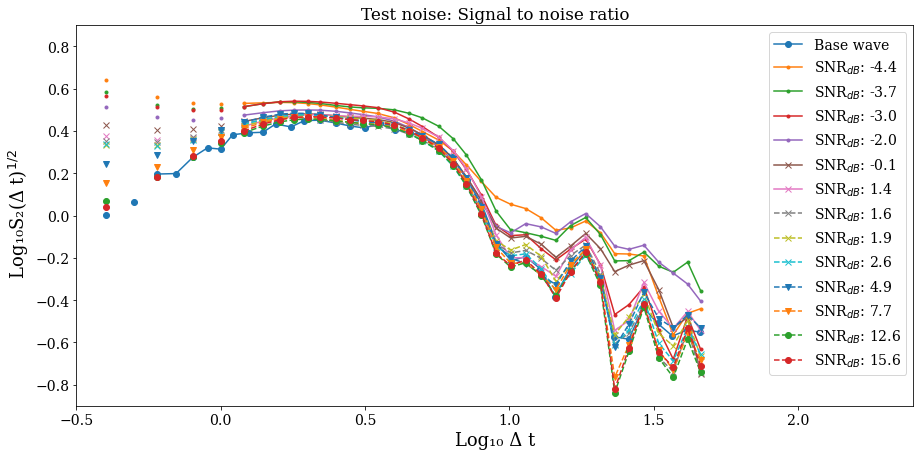

In [167]:
plt.subplots(figsize=(15,7))
plt.title('Test noise: Signal to noise ratio')
plt.plot(no_uni_time3,np.log10(no_uni_amp3),'o-',label='Base wave')


plt.plot(time8,np.log10(amp8),'.-',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR8),1)))
plt.plot(time7,np.log10(amp7),'.-',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR7),1)))

plt.plot(time_05,np.log10(amp_05),'.-',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR05),1)))

plt.plot(time3,np.log10(amp3),'.-',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR3),1)))
plt.plot(time4,np.log10(amp4),'x-',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR4),1)))
plt.plot(time6,np.log10(amp6),'x-',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR6),1)))
plt.plot(time1,np.log10(amp1),'x--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR1),1)))
plt.plot(time2,np.log10(amp2),'x--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR2),1)))
plt.plot(time5,np.log10(amp5),'x--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR5),1)))
plt.plot(time9,np.log10(amp9),'v--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR9),1)))
plt.plot(time10,np.log10(amp10),'v--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR10),1)))
plt.plot(time11,np.log10(amp11),'o--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR11),1)))
plt.plot(time12,np.log10(amp12),'o--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR12),1)))

plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);
#plt.ylabel(' S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.ylabel(' Log\u2081\u2080S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.legend(loc=1)
plt.ylim([-0.9,0.9])
plt.xlim([-0.5,2.4])
#plt.savefig('SIGNAL TO NOISE LOG RATIO dB.jpg',bbox_inches='tight')
plt.show()

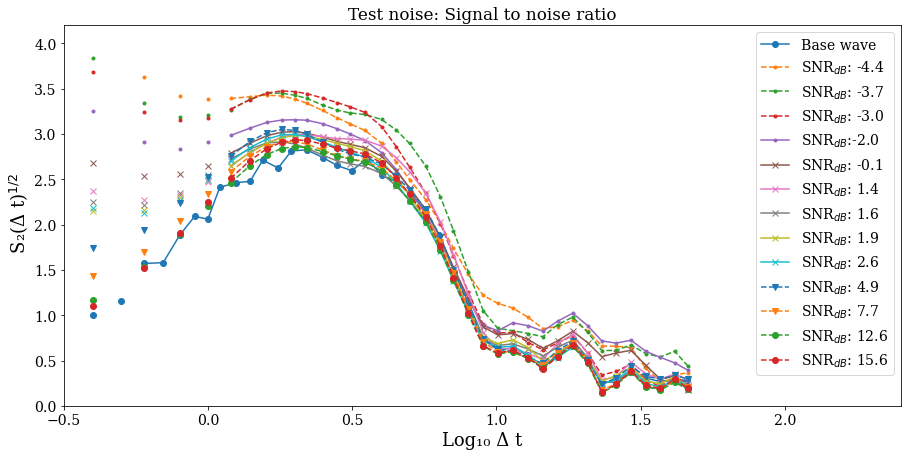

In [162]:
plt.subplots(figsize=(15,7))
plt.title('Test noise: Signal to noise ratio')
plt.plot(no_uni_time3,(no_uni_amp3),'o-',label='Base wave')

plt.plot(time8,(amp8),'.--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR8),1)))
plt.plot(time7,(amp7),'.--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR7),1)))

plt.plot(time_05,(amp_05),'.--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR05),1)))

plt.plot(time3,(amp3),'.-',label='SNR'+r'$_{dB}$:'+str(np.round(10*np.log10(SNR3),1)))
plt.plot(time4,(amp4),'x-',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR4),1)))
plt.plot(time6,(amp6),'x-',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR6),1)))
plt.plot(time1,(amp1),'x-',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR1),1)))
plt.plot(time2,(amp2),'x-',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR2),1)))
plt.plot(time5,(amp5),'x-',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR5),1)))
plt.plot(time9,(amp9),'v--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR9),1)))
plt.plot(time10,(amp10),'v--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR10),1)))
plt.plot(time11,(amp11),'o--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR11),1)))
plt.plot(time12,(amp12),'o--',label='SNR'+r'$_{dB}$: '+str(np.round(10*np.log10(SNR12),1)))


plt.xlabel('Log\u2081\u2080 \u0394 t',fontsize=18);
plt.ylabel(' S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
#plt.ylabel(' Log\u2081\u2080S\u2082(\u0394 t)'+r'$^{1/2}$',fontsize=18)
plt.legend()
plt.ylim([0,4.2])
plt.xlim([-0.5,2.4])
#plt.savefig('SIGNAL TO NOISE RATIO dB.jpg',bbox_inches='tight')
plt.show()

In [154]:
print('SNR n1: ',10*np.log10(SNR1))
print('SNR n2: ',10*np.log10(SNR2))
print('SNR n3: ',10*np.log10(SNR3))

print('SNR Z05: ',10*np.log10(SNR05))

print('SNR n4: ',10*np.log10(SNR4))
print('SNR n5: ',10*np.log10(SNR5))
print('SNR n6: ',10*np.log10(SNR6))
print('SNR n7: ',10*np.log10(SNR7))
print('SNR n8: ',10*np.log10(SNR8))
print('SNR n9: ',10*np.log10(SNR9))
print('SNR n10: ',10*np.log10(SNR10))
print('SNR n11: ',10*np.log10(SNR11))
print('SNR n12: ',10*np.log10(SNR12))

SNR n1:  1.6136800223497487
SNR n2:  1.903316981702915
SNR n3:  -2.0065945054641827
SNR Z05:  -3.010299956639812
SNR n4:  -0.1322826573375516
SNR n5:  2.576785748691845
SNR n6:  1.4301480025409505
SNR n7:  -3.6653154442041345
SNR n8:  -4.436974992327127
SNR n9:  4.927603890268375
SNR n10:  7.701152947871016
SNR n11:  12.586372827240764
SNR n12:  15.624118329497275
